In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from torchvision.transforms import Compose, ToTensor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = "InfraredSolarModules/" + self.dataframe.iloc[idx]['image_filepath']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        if self.transform:
            img = self.transform(img)
        label = int(self.dataframe.iloc[idx]['class_code'])
        return img, label

In [3]:
# Read data
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [4]:
def map_to_class(value):
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [5]:
# Split data indices
datos = list(range(0,len(DataSolarModules)))
np.random.shuffle(datos)
data_train_idx, data_test_idx = train_test_split(datos, test_size=0.2)
data_train_idx, data_val_idx = train_test_split(data_train_idx, test_size=0.25)

In [6]:
# Get corresponding data using indices
data_train = DataSolarModules.iloc[data_train_idx]
data_val = DataSolarModules.iloc[data_val_idx]
data_test = DataSolarModules.iloc[data_test_idx]

In [7]:
# Prepare datasets and data loaders
transform = Compose([ToTensor()])
train_dataset = CustomDataset(data_train, transform=transform)
val_dataset = CustomDataset(data_val, transform=transform)
test_dataset = CustomDataset(data_test, transform=transform)

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# Define CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=2, stride=2, padding=1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = self.maxpool(x)
        x = nn.ReLU()(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
# Train CNN and Decision Tree jointly
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN(num_classes=len(Classes)).to(device)
criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.003)
decision_tree = DecisionTreeClassifier()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        cnn_optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Validation loss
    cnn_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_losses.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

Epoch [1/100], Train Loss: 1.7712, Val Loss: 1.6540
Epoch [2/100], Train Loss: 1.6033, Val Loss: 1.5935
Epoch [3/100], Train Loss: 1.5580, Val Loss: 1.5718
Epoch [4/100], Train Loss: 1.5321, Val Loss: 1.5327
Epoch [5/100], Train Loss: 1.5126, Val Loss: 1.5252
Epoch [6/100], Train Loss: 1.5068, Val Loss: 1.5129
Epoch [7/100], Train Loss: 1.4958, Val Loss: 1.4949
Epoch [8/100], Train Loss: 1.4665, Val Loss: 1.4761
Epoch [9/100], Train Loss: 1.4360, Val Loss: 1.4273
Epoch [10/100], Train Loss: 1.4092, Val Loss: 1.4027
Epoch [11/100], Train Loss: 1.3866, Val Loss: 1.3804
Epoch [12/100], Train Loss: 1.3710, Val Loss: 1.3839
Epoch [13/100], Train Loss: 1.3659, Val Loss: 1.3504
Epoch [14/100], Train Loss: 1.3526, Val Loss: 1.3543
Epoch [15/100], Train Loss: 1.3529, Val Loss: 1.4182
Epoch [16/100], Train Loss: 1.3451, Val Loss: 1.3402
Epoch [17/100], Train Loss: 1.3357, Val Loss: 1.3463
Epoch [18/100], Train Loss: 1.3233, Val Loss: 1.3808
Epoch [19/100], Train Loss: 1.3245, Val Loss: 1.3370
Ep

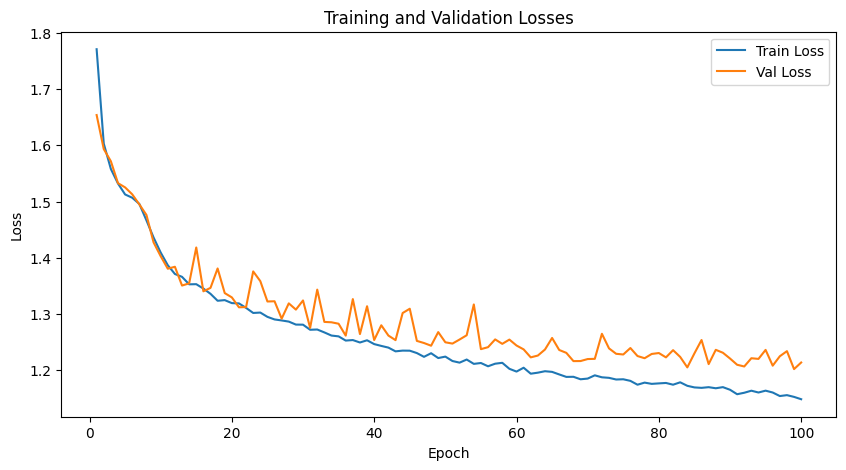

In [11]:
# Plotting the Loss Graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [12]:
# Update decision tree with new features
cnn_model.eval()
train_features = []
train_labels = []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        output = cnn_model(images)
        train_features.append(output.cpu().numpy())
        train_labels.append(labels.numpy())
train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)
decision_tree.fit(train_features, train_labels)

DecisionTreeClassifier()

In [13]:
# Evaluate Decision Tree
test_features = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = cnn_model(images)
        test_features.append(output.cpu().numpy())
        test_labels.append(labels.numpy())
test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)
accuracy = decision_tree.score(test_features, test_labels)
print(f"Decision Tree Accuracy on test set: {accuracy * 100:.2f}%")

Decision Tree Accuracy on test set: 50.42%


<function matplotlib.pyplot.show(close=None, block=None)>

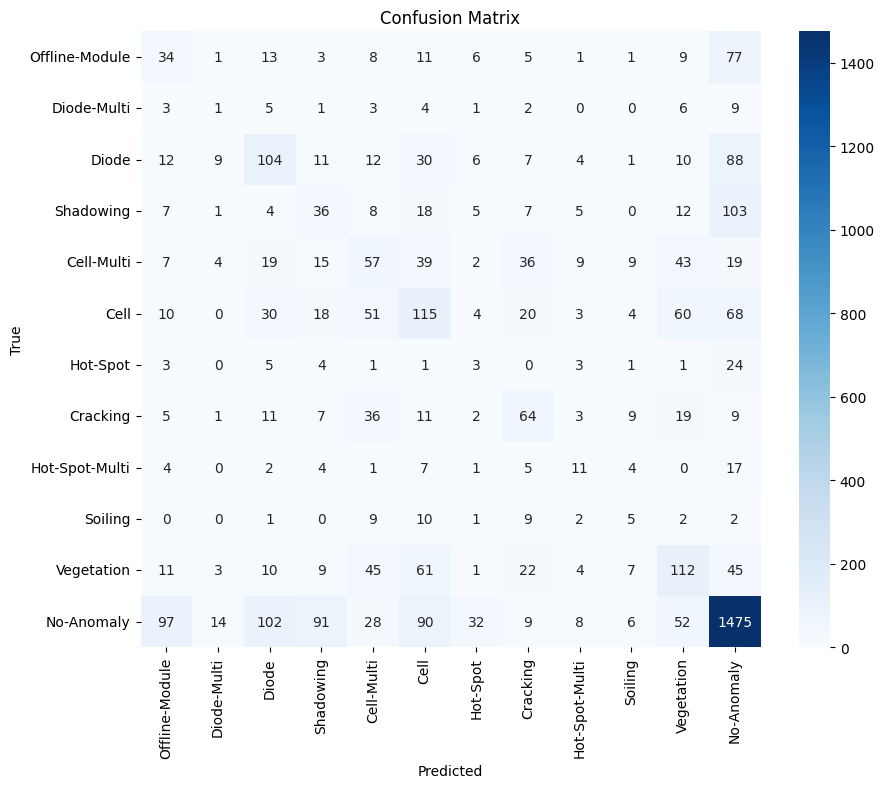

In [14]:
# Confusion Matrix
predictions = decision_tree.predict(test_features)
cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=Classes, yticklabels=Classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show